## Libraries

In [60]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

rs = 331438

### Loading csv file

In [2]:
df_dev = pd.read_csv('development.csv')
df_eval = pd.read_csv('evaluation.csv')

print('First rows of the Development DataFrames are:')
display(df_dev.head())
print('First rows of the Development DataFrames are:')
display(df_eval.head())

First rows of the Development DataFrames are:


,x,y,pmax[0],negpmax[0],area[0],tmax[0],rms[0],pmax[1],negpmax[1],area[1],...,pmax[16],negpmax[16],area[16],tmax[16],rms[16],pmax[17],negpmax[17],area[17],tmax[17],rms[17]
0,200.0,200.0,4.066907,-17.690173,2.847932,0.600000,2.007042,5.409161,-17.721210,4.538778,...,607.109118,-36.282996,583.899899,72.373094,0.374498,614.916861,-39.848523,591.852768,72.331028,0.405595
1,200.0,200.0,5.916801,-4.717111,5.792778,79.765174,1.564535,4.414289,-4.736827,3.720435,...,630.348007,-39.715988,580.042799,71.029155,0.403258,624.950701,-41.266681,586.569646,71.089058,0.405890
2,200.0,200.0,4.286652,-5.316132,2.356390,74.600000,1.404622,4.567191,-5.985437,3.490490,...,613.880342,-40.679678,580.407491,71.892264,0.568777,596.437125,-42.712286,574.091695,71.943934,0.498019
3,200.0,200.0,4.003635,-4.617459,2.189005,43.000000,1.512162,5.019058,-4.229949,6.786200,...,600.714957,-43.206601,579.882635,72.357388,0.255483,591.763739,-50.681940,584.099483,72.333282,0.336454
4,200.0,200.0,4.448146,-4.848743,3.997002,196.667482,1.101113,3.250262,-5.783587,2.449456,...,609.723785,-43.570892,590.156125,71.249130,0.413855,606.917023,-49.923819,584.316142,71.242904,0.293824


First rows of the Development DataFrames are:


,Id,pmax[0],negpmax[0],area[0],tmax[0],rms[0],pmax[1],negpmax[1],area[1],tmax[1],...,pmax[16],negpmax[16],area[16],tmax[16],rms[16],pmax[17],negpmax[17],area[17],tmax[17],rms[17]
0,0,4.400616,-4.257770,2.860212,176.600000,1.562814,8.738040,-3.598874,5.554105,70.800000,...,614.621212,-42.232574,583.237137,70.693530,0.861022,608.931417,-42.728827,568.019556,70.755552,0.328075
1,1,5.599571,-2.974570,9.400537,90.677386,1.129626,23.460358,-20.616669,17.998419,72.800000,...,520.333440,-36.986118,550.540448,72.781390,0.259205,613.671695,-44.449564,586.292097,72.900695,0.401326
2,2,3.731995,-5.662292,1.930957,155.200000,0.921757,4.837952,-7.224267,3.289124,67.057395,...,607.642389,-46.680069,582.825835,71.407320,0.552691,608.996069,-45.877765,589.520958,71.406020,0.343592
3,3,5.657729,-4.600342,5.593030,30.463179,1.269390,87.293692,-45.786813,38.422989,71.800000,...,596.094911,-48.241263,577.835129,72.011986,0.361220,612.500144,-49.572583,583.795426,72.066338,0.429650
4,4,3.716666,-4.583796,1.946927,33.600000,1.082743,9.593125,-5.374179,7.767408,72.414459,...,620.793628,-37.618567,599.834735,72.251813,0.390639,621.557649,-45.189832,600.988676,72.151243,0.358549


A potentially interesting information regards the existance of empty (or Not a Number) values.


In [3]:
NaN_dev_mask = df_dev.isna().any(axis=0)
NaN_eval_mask = df_eval.isna().any(axis=0)

print(f'NaN values for developments.csv: \t{NaN_dev_mask[NaN_dev_mask == True]}')
print(f'NaN values for evaluation.csv: \t\t{NaN_eval_mask[NaN_eval_mask == True]}')


NaN values for developments.csv: 	Series([], dtype: bool)
NaN values for evaluation.csv: 		Series([], dtype: bool)


No presence of NaN values

## Outliers

In [71]:
outlier_counts = pd.Series()

# Itera attraverso le colonne del DataFrame e conta gli outlier per ciascuna feature
for column in df_dev.iloc[:,2:].columns:
    # Calcola i limiti del box plot
    Q1 = df_eval[column].quantile(0.25)
    Q3 = df_eval[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identifica gli outlier
    outliers = df_eval[(df_eval[column] < lower_bound) | (df_eval[column] > upper_bound)][column]

    # Conta gli outlier e aggiungi il conteggio alla Series
    outlier_counts[column] = len(outliers)

# Visualizza la Pandas Series con i conteggi degli outlier
print(outlier_counts[outlier_counts==0])

tmax[0]     0
tmax[7]     0
tmax[12]    0
tmax[15]    0
tmax[16]    0
tmax[17]    0
dtype: int64


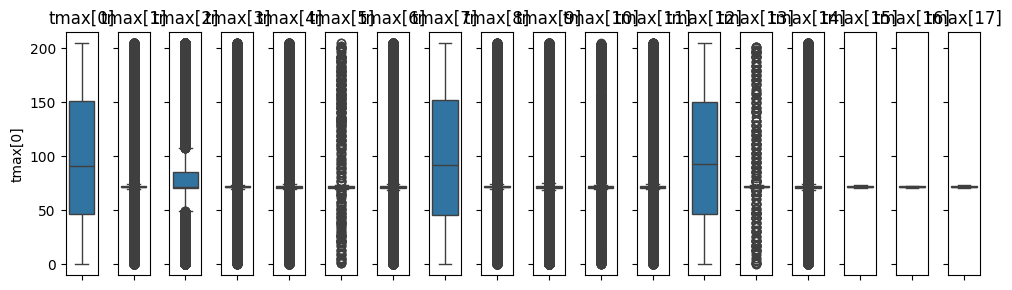

In [82]:
# Numero di colonne desiderate (una colonna per ogni feature)
num_columns = 18  # Adattare il numero di colonne in base al numero di tmax[0] ... tmax[17]

# Crea una griglia di subplot
fig, axes = plt.subplots(1, num_columns, figsize=(10, 3), sharey=True)

# Itera attraverso gli indici delle colonne tmax[0], tmax[1], ..., tmax[17]
for i in range(num_columns):
    # Seleziona la colonna corrispondente dal DataFrame
    column_name = f'tmax[{i}]'
    sns.boxplot(y=df_eval[column_name], ax=axes[i])
    axes[i].set_title(f'{column_name}')

# Aggiusta la disposizione dei subplot
plt.tight_layout()

# Mostra il plot
plt.show()

## Noise

Let's evaluate the presence of noise in the data. It is known that only 12 pads are real measuration. In order to do so, different methods:
- SNR estimation
- Correlation of the features

In [4]:
df_dev_features = df_dev.drop(columns=['x', 'y'])

Selecting the 6 worst SNR ...


100%|██████████| 257000/257000 [01:18<00:00, 3258.84it/s]


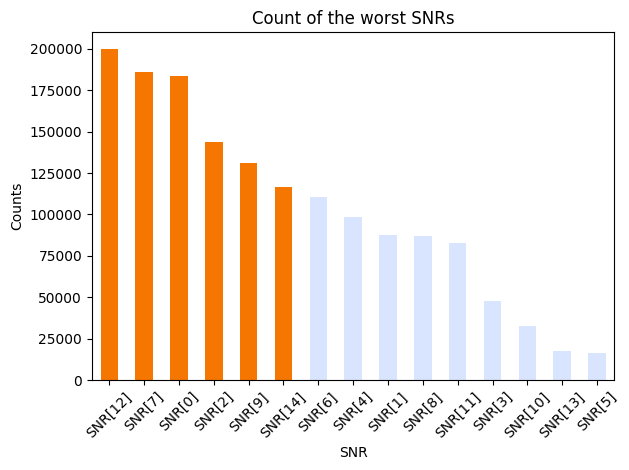

In [5]:
# STRATEGY 1: the area is the signal and RMS is the white noise

rms_start_column = 'rms[0]'
area_start_column = 'area[0]'

area_start_index = df_dev_features.columns.get_loc(area_start_column)
area_columns_name = [df_dev_features.iloc[:, area_start_index+5*i].name for i in range(0, 18)]

rms_start_index = df_dev_features.columns.get_loc(rms_start_column)
rms_columns_name = [df_dev_features.iloc[:, rms_start_index+5*i].name for i in range(0, 18)]


S = df_dev_features[area_columns_name]
N = df_dev_features[rms_columns_name]**2

snr_name_columns = [f'SNR[{i}]' for i in range(18)]
# Selecting the absolute value of S: what does matter is the amplitude of the signal only
SNR = pd.DataFrame(10*np.log10(np.abs(S.to_numpy())/N.to_numpy()), columns=snr_name_columns)

worst_SNR_list = []
# Taking a small fraction of SNR Dataframe
SNR_frac = SNR.sample(frac=2/3, random_state=331438)
print('Selecting the 6 worst SNR ...')
for i in tqdm(range((len(SNR_frac)))):
    worst_SNR_list.append(SNR_frac.iloc[i,:].sort_values(ascending=False).iloc[12:].index.to_list())

# Once created, merge all the lists in a single list    
worst_SNR_list = [worst_SNR for SNR_list in worst_SNR_list for worst_SNR in SNR_list]
# Converting the list in a Serie to use value_counts()
worst_SNR_counts = pd.Series(worst_SNR_list).value_counts()

# PLOT
colors = ['#f57600' if i < 6 else '#d9e4ff' for i in range(len(worst_SNR_counts))]
worst_SNR_counts.plot(kind='bar', color=colors)
plt.xlabel('SNR')
plt.ylabel('Counts')
plt.title('Count of the worst SNRs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Correlation method

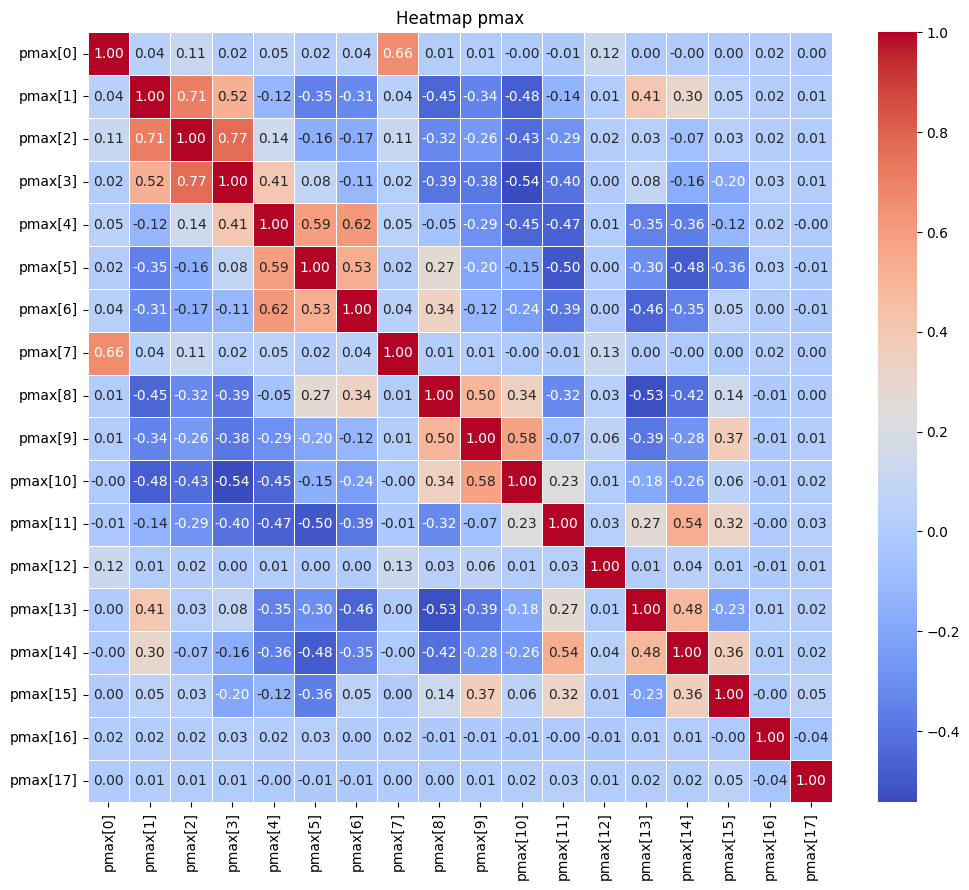

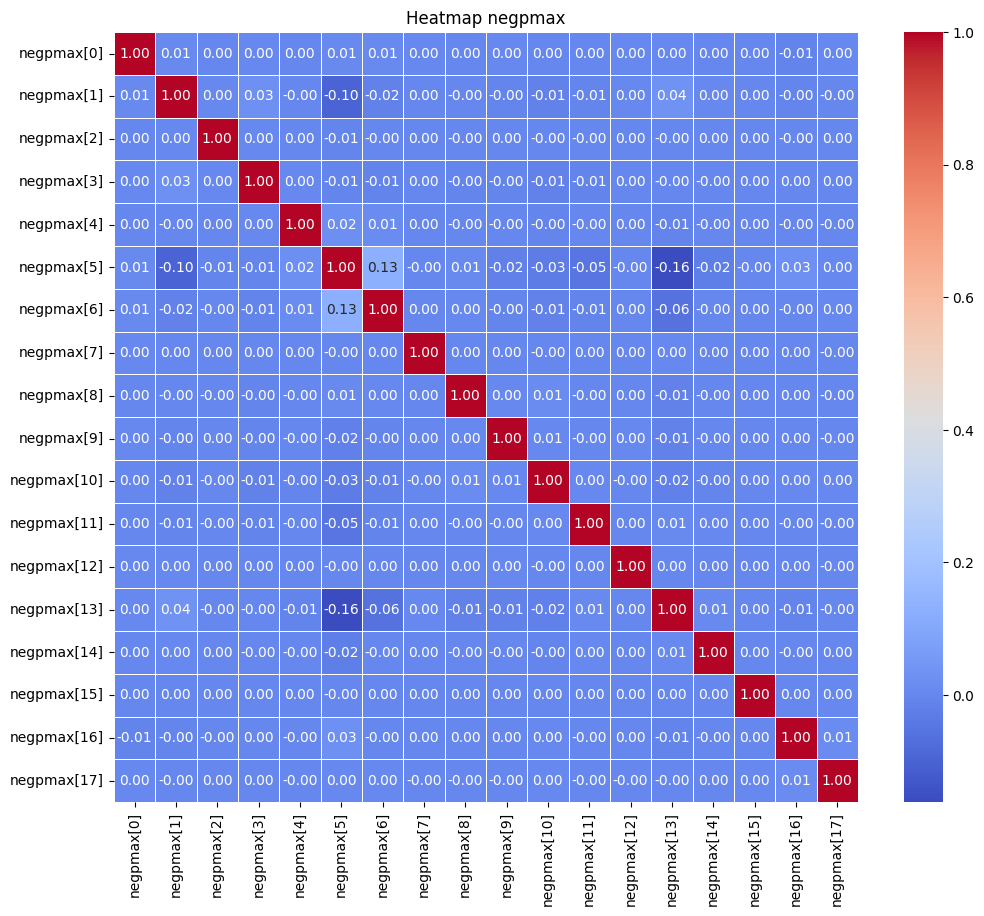

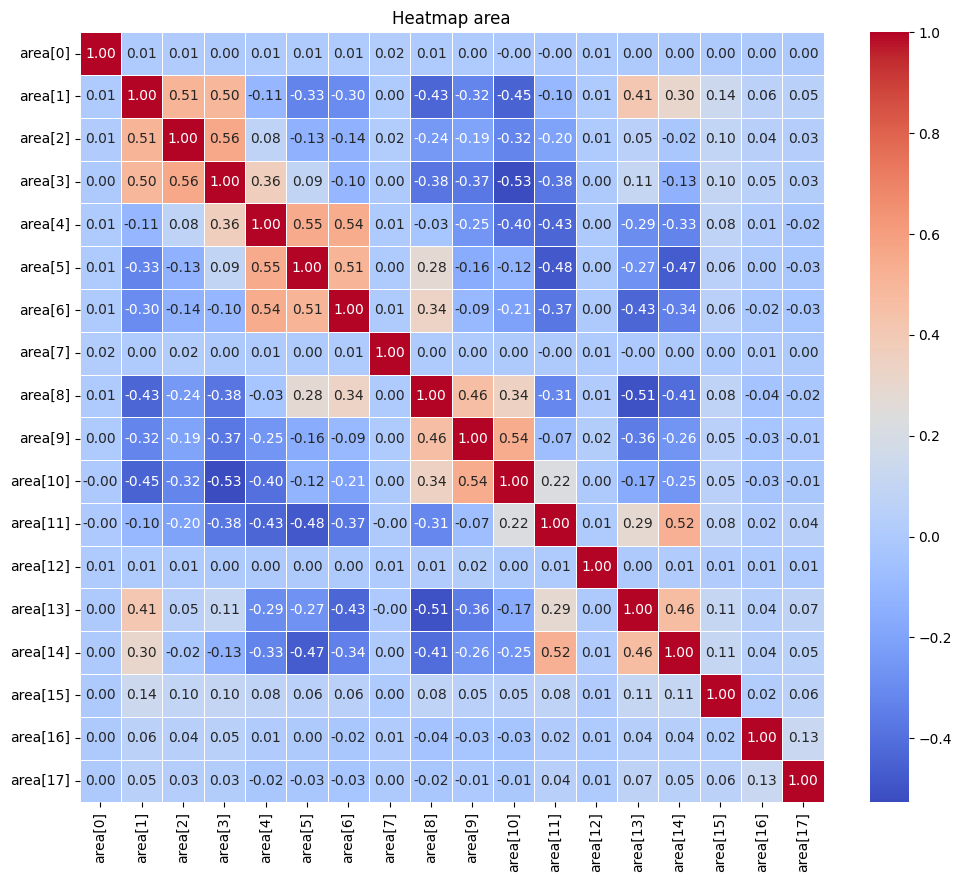

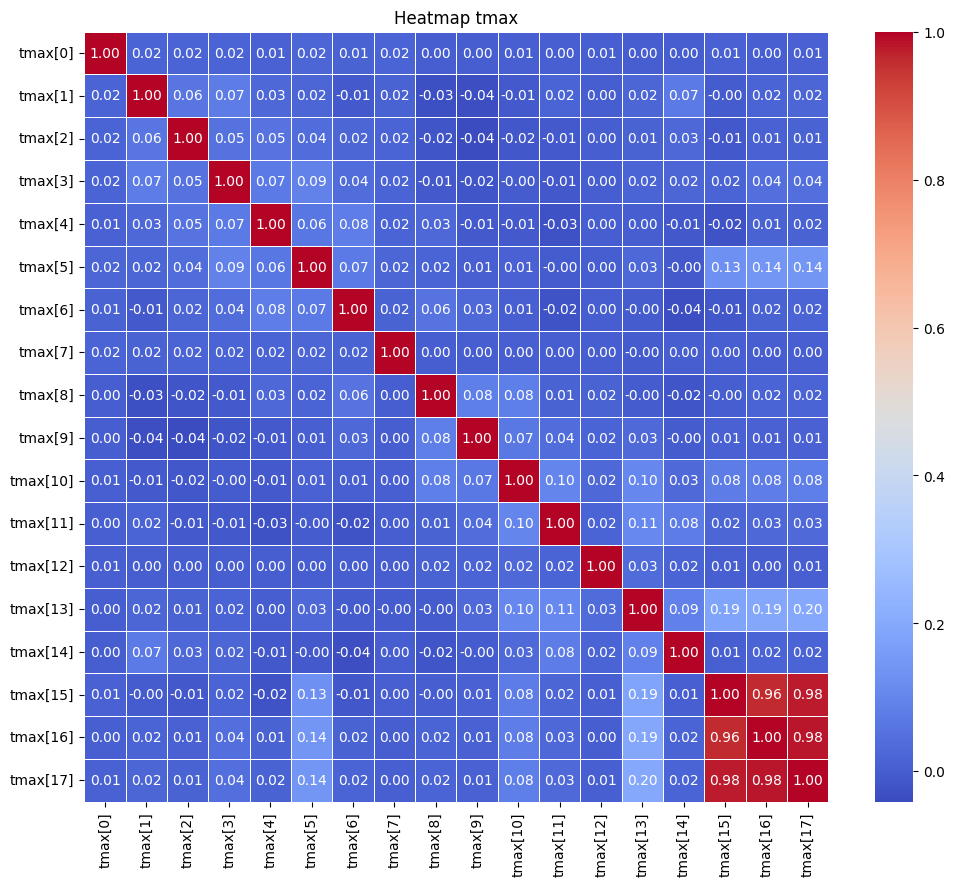

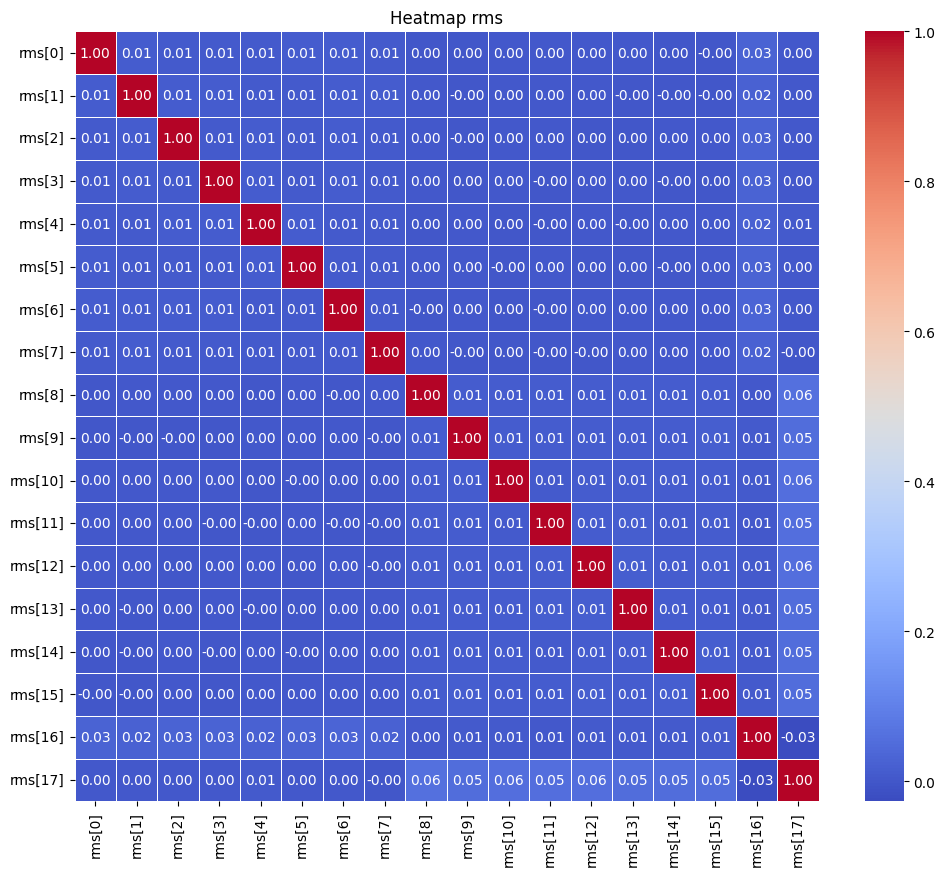

In [61]:
# Correlation
# Every df is taken from the development dataset
df_pmax = df_dev.iloc[:,[i+2 for i in range(0,len(df_eval.columns)-2,5)]]
df_negpmax = df_dev.iloc[:,[i+3 for i in range(0,len(df_eval.columns)-2,5)]]
df_area = df_dev.iloc[:,[i+4 for i in range(0,len(df_eval.columns)-2,5)]]
df_tmax = df_dev.iloc[:,[i+5 for i in range(0,len(df_eval.columns)-2,5)]]
df_rms = df_dev.iloc[:,[i+6 for i in range(0,len(df_eval.columns)-2,5)]]

corr_pmax = df_pmax.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_pmax, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Heatmap pmax")
plt.show()

corr_negpmax = df_negpmax.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_negpmax, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Heatmap negpmax")
plt.show()

corr_area = df_area.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_area, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Heatmap area")
plt.show()

corr_tmax = df_tmax.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_tmax, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Heatmap tmax")
plt.show()

corr_rms = df_rms.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_rms, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Heatmap rms")
plt.show()

The two methods leads to different columns (column type[6] and column type[14]): it is possible to understand this result thanks to the SNR analysis. In fact, the two columns have more or less SNR similar value.

This suggest that 1 pad of the 12 has not negligible noise.

In [6]:
list_index_noise = [0, 2, 7, 9, 12, 14]
padname_list = df_dev.iloc[1,2:7].index.to_list()
padname_list = [item.replace('[0]', '') for item in padname_list]
list_column_noise = [f'{padname}[{i}]' for padname in padname_list for i in list_index_noise]

df_dev_denoised_snr = df_dev.drop(columns=list_column_noise)
df_eval_denoised_snr = df_eval.drop(columns=list_column_noise)

list_index_noise = [0, 7, 12, 15, 16, 17]
padname_list = df_dev.iloc[1,2:7].index.to_list()
padname_list = [item.replace('[0]', '') for item in padname_list]
list_column_noise = [f'{padname}[{i}]' for padname in padname_list for i in list_index_noise]

df_dev_denoised_corr = df_dev.drop(columns=list_column_noise)
df_eval_denoised_corr = df_eval.drop(columns=list_column_noise)

## PCA analysis

In [7]:
denoised_features_list = df_dev_denoised_snr.drop(columns=['x', 'y']).columns.to_list()
Xworkdf = df_dev_denoised_snr[denoised_features_list]

STDscaler = StandardScaler()
MMscaler = MinMaxScaler()
Xworkdf_std = STDscaler.fit_transform(Xworkdf)
Xworkdf_mm = MMscaler.fit_transform(Xworkdf)

Xworkdf_std = pd.DataFrame(Xworkdf_std, columns=Xworkdf.columns)
Xworkdf_mm = pd.DataFrame(Xworkdf_mm, columns=Xworkdf.columns)

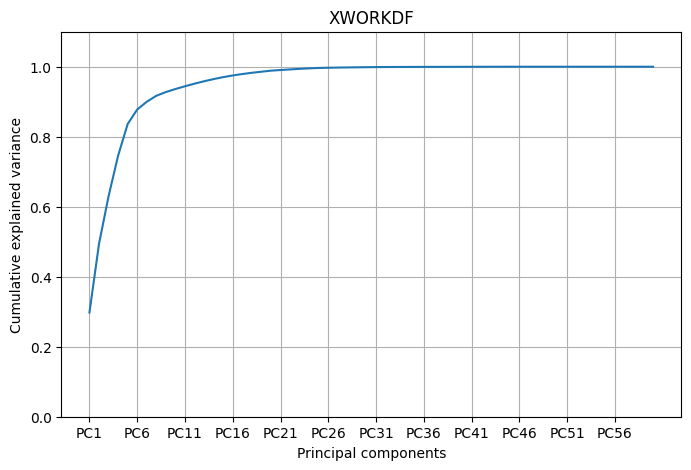

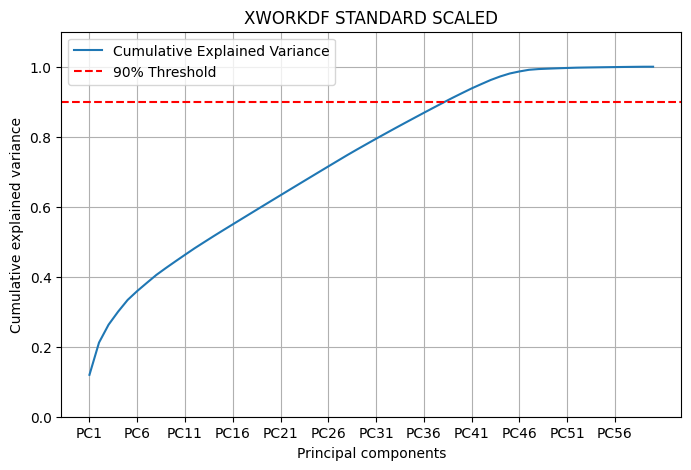

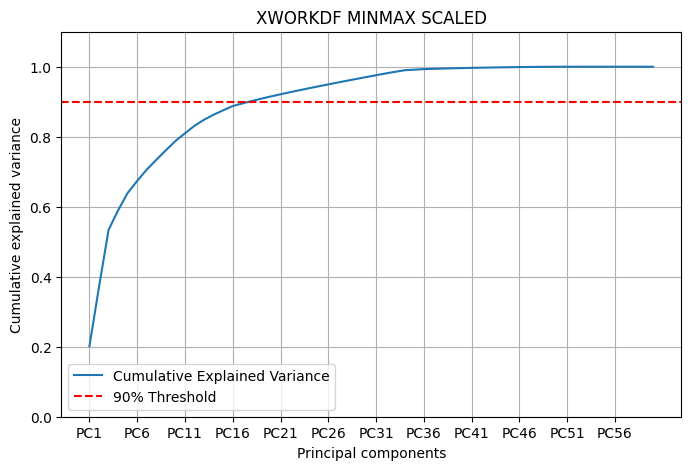

In [8]:
pca_nostd = PCA(random_state=rs)
pca_std = PCA(random_state=rs)
pca_mm = PCA(random_state=rs)

pca_nostd.fit(Xworkdf)
pca_std.fit(Xworkdf_std)
pca_mm.fit(Xworkdf_mm)

explained_variance_std = np.cumsum(pca_std.explained_variance_ratio_)
explained_variance_mm = np.cumsum(pca_mm.explained_variance_ratio_)

#pca_nostd
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca_nostd.explained_variance_ratio_))
plt.title('XWORKDF')
plt.ylim([0, 1.1])
plt.xticks(ticks=np.arange(0,pca_nostd.n_features_in_,5), 
           labels=[f'PC{i + 1}' for i in range(0,pca_nostd.n_features_in_,5)])
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.grid()
plt.show()


#pca_std
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca_std.explained_variance_ratio_))
plt.axhline(y=0.90, color='r', linestyle='--')
plt.title('XWORKDF STANDARD SCALED')
plt.ylim([0, 1.1])
plt.xticks(ticks=np.arange(0, pca_std.n_features_in_, 5), 
           labels=[f'PC{i + 1}' for i in range(0, pca_std.n_features_in_, 5)])
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.legend(['Cumulative Explained Variance', '90% Threshold']) 
plt.grid()
plt.show()

#pca_mm
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca_mm.explained_variance_ratio_))
plt.axhline(y=0.90, color='r', linestyle='--')
plt.title('XWORKDF MINMAX SCALED')
plt.ylim([0, 1.1])
plt.xticks(ticks=np.arange(0,pca_mm.n_features_in_,5), 
           labels=[f'PC{i + 1}' for i in range(0, pca_mm.n_features_in_, 5)])
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.legend(['Cumulative Explained Variance', '90% Threshold']) 
plt.grid()
plt.show()


90% of information

In [9]:
n_std = np.argmax(explained_variance_std >= 0.90) + 1
n_mm = np.argmax(explained_variance_mm >= 0.90) + 1

print(f'Number of PCs selected (Standard Scaler): {n_std}')
print(f'Number of PCs selected (MinMax Scaler): {n_mm}')

pca_std = PCA(n_components=n_std, random_state = rs)
pca_mm = PCA(n_components=n_mm, random_state = rs)

Number of PCs selected (Standard Scaler): 39
Number of PCs selected (MinMax Scaler): 18


### Regressor

In [10]:

X_corr = df_dev_denoised_corr.iloc[:,2:].values
X_snr = df_dev_denoised_snr.iloc[:,2:].values
X_std = pca_std.fit_transform(Xworkdf_std)
X_mm = pca_mm.fit_transform(Xworkdf_mm)

y = df_dev[['x','y']].values

X_corr_train, X_corr_valid, y_corr_train, y_corr_valid = train_test_split(X_corr, y, shuffle=True, random_state=rs, train_size=.8)
X_snr_train, X_snr_valid, y_snr_train, y_snr_valid = train_test_split(X_snr, y, shuffle=True, random_state=rs, train_size=.8)
X_std_train, X_std_valid, y_std_train, y_std_valid = train_test_split(X_std, y, shuffle=True, random_state=rs, train_size=.8)
X_mm_train, X_mm_valid, y_mm_train, y_mm_valid = train_test_split(X_mm, y, shuffle=True, random_state=rs, train_size=.8)

To train a random forest, let's see the maximum depth of a decision tree

In [11]:
reg_dec = DecisionTreeRegressor()
reg_dec.fit(X_snr_train, y_snr_train)
max_depth_snr = reg_dec.get_depth()
print(f"Maximum depth (SNR): {max_depth_snr}")

reg_dec.fit(X_corr_train, y_corr_train)
max_depth_corr = reg_dec.get_depth()
print(f"Maximum depth (Correlation): {max_depth_corr}")

reg_dec.fit(X_std_train, y_std_train)
max_depth_std = reg_dec.get_depth()
print(f"Maximum depth (STD): {max_depth_std}")

reg_dec.fit(X_mm_train, y_mm_train)
max_depth_mm = reg_dec.get_depth()
print(f"Maximum depth (MinMax): {max_depth_mm}")

Maximum depth (SNR): 31
Maximum depth (Correlation): 29
Maximum depth (STD): 40
Maximum depth (MinMax): 35


We can now train a random forest with the default parameters to establish an initial baseline.

In [12]:
def distance(x_vec, y_vec):
    return sum(np.linalg.norm(x_vec-y_vec, axis=1))/x_vec.shape[0]

Grid Search for the best of the best

In [ ]:
from sklearn.metrics import make_scorer

euclidean_score = make_scorer(distance, greater_is_better=False)

parameters = {
    'min_samples_leaf':[2, 3, 5],
    'min_samples_split':[1, 2, 4, 8],
}

random_forest_snr = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_features='sqrt', max_depth=max_depth_snr, verbose=10)
random_forest_corr = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_features='sqrt',max_depth=max_depth_corr,verbose=10)
random_forest_std = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_features='sqrt',max_depth=max_depth_std,verbose=10)
random_forest_mm = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_features='sqrt',max_depth=max_depth_mm,verbose=10)

grid_search_snr = GridSearchCV(random_forest_snr, parameters, cv=3, scoring=euclidean_score, n_jobs=-1)
grid_search_corr = GridSearchCV(random_forest_corr, parameters, cv=3, scoring=euclidean_score, n_jobs=-1)
grid_search_std = GridSearchCV(random_forest_std, parameters, cv=3, scoring=euclidean_score, n_jobs=-1)
grid_search_mm = GridSearchCV(random_forest_mm, parameters, cv=3, scoring=euclidean_score, n_jobs=-1)

grid_search_snr.fit(X_snr_train, y_snr_train)
grid_search_corr.fit(X_corr_train, y_corr_train)
grid_search_std.fit(X_std_train, y_std_train)
grid_search_mm.fit(X_mm_train, y_mm_train)

In [45]:
dic_model = {'grid_search_snr': grid_search_snr, 'grid_search_corr': grid_search_corr, 'grid_search_std': grid_search_std, 'grid_search_mm': grid_search_mm}
best_measure = -grid_search_snr.best_score_
best_model = None

for model_name, model in dic_model.items():
    if -model.best_score_ < best_measure:
        best_model = model
        best_measure = -model.best_score_
        model_grid_str = model_name
        
print(f'Best model: {model_grid_str}\nbest params: {best_model.best_params_}\nmean euclidean distance: {best_measure}')

Best model: grid_search_corr
best params: {'min_samples_leaf': 2, 'min_samples_split': 4}
mean euclidean distance: 4.724274838569664


In [52]:
reg_corr = RandomForestRegressor(n_jobs=-1, max_features='sqrt', n_estimators=100, max_depth=max_depth_corr, min_samples_leaf=2,min_samples_split=4, verbose=10)
reg_corr.fit(X_corr_train, y_corr_train)
distances = distance(y_corr_valid, reg_corr.predict(X_corr_valid))
mean_distance = np.mean(distances)
mean_distance

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    3.7s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.9s finished


4.57777641772185

In [ ]:
X_corr_test = df_eval_denoised_corr.drop(columns=['Id']).values
y_pred = reg_corr.predict(X_corr_test)

df_sample_submission = pd.DataFrame({'Id': df_eval['Id'].astype(int)})
df_sample_submission['Predicted'] = ['|'.join(map(str, values)) for values in y_pred]
df_sample_submission.to_csv('sample_submission.csv', index=False)
# 5.117 (expected 4.578)

In [35]:
best_features = df_dev_denoised_corr.drop(columns=['x','y']).columns.to_list()
best_features = sorted(zip(best_features, reg_corr.feature_importances_), key=lambda x: x[1], reverse=True)

best_features1 = [item[0] for item in best_features if 'tmax' not in item[0] and 'rms' not in item[0]] # No tmax and rms
best_features2 = [item[0] for item in best_features if 'rms' not in item[0]] # no rms
best_features3 = [item[0] for item in best_features if 'tmax' not in item[0]] #no tmax

Discarding tmax and rms

In [54]:
reg_corr1 = RandomForestRegressor(n_jobs=-1, max_features='sqrt', n_estimators=100, max_depth=max_depth_corr, min_samples_leaf=2,min_samples_split=4, verbose=10)
df_dev_best = df_dev_denoised_corr[best_features1]

X_best = df_dev_best.values
X_best_train, X_best_valid, y_best_train, y_best_valid = train_test_split(X_best, y, shuffle=True, random_state=rs, train_size=.8)
reg_corr1.fit(X_best_train, y_best_train)
distances = distance(y_best_valid, reg_corr1.predict(X_best_valid))
mean_distance = np.mean(distances)
display(mean_distance)

df_eval_best = df_eval_denoised_corr[best_features1]
X_best_test = df_eval_best.values
y_pred = reg_corr1.predict(X_best_test)

df_sample_submission = pd.DataFrame({'Id': df_eval['Id'].astype(int)})
df_sample_submission['Predicted'] = ['|'.join(map(str, values)) for values in y_pred]
df_sample_submission.to_csv('sample_submission.csv', index=False)
# 4.881 (expected 4.257)

4.2566439738234845

discarding only rms

In [56]:
reg_corr2 = RandomForestRegressor(n_jobs=-1, max_features='sqrt', n_estimators=100, max_depth=max_depth_corr, min_samples_leaf=2,min_samples_split=4, verbose=10)
df_dev_best2 = df_dev_denoised_corr[best_features2]
X_best2 = df_dev_best2.values
X_best2_train, X_best2_valid, y_best2_train, y_best2_valid = train_test_split(X_best2, y, shuffle=True, random_state=rs, train_size=.8)
reg_corr2.fit(X_best2_train, y_best2_train)
distances = distance(y_best2_valid, reg_corr2.predict(X_best2_valid))
mean_distance = np.mean(distances)
mean_distance

df_eval_best2 = df_eval_denoised_corr[best_features2]
X_best2_test = df_eval_best2.values
y_pred = reg_corr2.predict(X_best2_test)

df_sample_submission = pd.DataFrame({'Id': df_eval['Id'].astype(int)})
df_sample_submission['Predicted'] = ['|'.join(map(str, values)) for values in y_pred]
df_sample_submission.to_csv('sample_submission.csv', index=False)
# 5.019 (expected 4.471)

4.47145918730658

discarding only tmax

In [58]:
reg_corr3 = RandomForestRegressor(n_jobs=-1, max_features='sqrt', n_estimators=100, max_depth=max_depth_corr, min_samples_leaf=2,min_samples_split=4, verbose=10)
df_dev_best3 = df_dev_denoised_corr[best_features3]
X_best3 = df_dev_best3.values
X_best3_train, X_best3_valid, y_best3_train, y_best3_valid = train_test_split(X_best3, y, shuffle=True, random_state=rs, train_size=.8)


reg_corr3.fit(X_best3_train, y_best3_train)
distances = distance(y_best3_valid, reg_corr3.predict(X_best3_valid))
mean_distance = np.mean(distances)
display(mean_distance)

df_eval_best3 = df_eval_denoised_corr[best_features3]
X_best3_test = df_eval_best3.values
y_pred = reg_corr3.predict(X_best3_test)

df_sample_submission = pd.DataFrame({'Id': df_eval['Id'].astype(int)})
df_sample_submission['Predicted'] = ['|'.join(map(str, values)) for values in y_pred]
df_sample_submission.to_csv('sample_submission.csv', index=False)
# 5.036 (expected 4.486)

4.486479750064692

trying another gridsearch

In [50]:
from sklearn.metrics import make_scorer

euclidean_score = make_scorer(distance, greater_is_better=False)

parameters = {
    'min_samples_leaf':[2, 3, 5],
    'min_samples_split':[1, 2, 4, 8],
    'min_impurity_decrease': [0.0, 0.01, 0.05],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2],
}

random_forest_corr_2 = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_features='sqrt', max_depth=max_depth_corr)
grid_search_corr_2 = GridSearchCV(random_forest_corr_2, parameters, cv=5, scoring=euclidean_score, n_jobs=-1)
grid_search_corr_2.fit(X_best_train, y_best_train)
print("best parameters:", grid_search_corr_2.best_params_)
print("best scoring:", grid_search_corr_2.best_score_)

c:\Users\_giov\Desktop\Universita\PoliTo\Magistrale\I_Anno\Data science Lab\LabWinter\env\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
135 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\_giov\Desktop\Universita\PoliTo\Magistrale\I_Anno\Data science Lab\LabWinter\env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\_giov\Desktop\Universita\PoliTo\Magistrale\I_Anno\Data science Lab\LabWinter\env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._valida

best parameters: {'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0}
best scoring: -4.313085532438022


In [84]:
grid_search_corr_2.get_params()

{'cv': 5,
 'error_score': nan,
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'squared_error',
 'estimator__max_depth': 29,
 'estimator__max_features': 'sqrt',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': -1,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestRegressor(max_depth=29, max_features='sqrt', n_jobs=-1),
 'n_jobs': -1,
 'param_grid': {'min_samples_leaf': [2, 3, 5],
  'min_samples_split': [1, 2, 4, 8],
  'min_impurity_decrease': [0.0, 0.01, 0.05],
  'min_weight_fraction_leaf': [0.0, 0.1, 0.2]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': make_scorer(distance, great

In [51]:
reg_best = grid_search_corr_2.best_estimator_
y_pred = reg_best.predict(X_best_test)

df_sample_submission = pd.DataFrame({'Id': df_eval['Id'].astype(int)})
df_sample_submission['Predicted'] = ['|'.join(map(str, values)) for values in y_pred]
df_sample_submission.to_csv('sample_submission.csv', index=False)
# 4.877 (expected 4.313) BEST ONE

reg_prova = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_features='sqrt', max_depth=max_depth_corr, verbose=10, )